In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

In [2]:
# "Data" contains the E31 data including the mean std from the bootstrapping
Data = pd.read_csv('E57_LOPAC_with_bootstrap.csv')

Data = Data.rename(columns={'conc':'concentration'})

In [3]:
Data

,ID,Metadata_platename,Metadata_well,sen_score,std_sen_score,cell_no,number_sen,fraction_sen,concentration,row,well_ending,compound,boostrapped_senscore_mean_std,boostrapped_numcells_mean_std
0,E57L458-0-5_A01,E57L458-0-5,A01,-0.912673,0.687237,908,88,0.096916,0.5,A,1,DMSO,NaN,NaN
1,E57L458-0-5_A02,E57L458-0-5,A02,-0.954459,0.693591,910,74,0.081319,0.5,A,2,DMSO,NaN,NaN
2,E57L458-0-5_A03,E57L458-0-5,A03,-1.009369,0.685404,971,74,0.076210,0.5,A,3,DL-alpha-Methyl-p-tyrosine,0.022119,7.701073
3,E57L458-0-5_A04,E57L458-0-5,A04,-1.049506,0.753196,903,79,0.087486,0.5,A,4,N-Acetyl-L-Cysteine,0.026677,7.203202
4,E57L458-0-5_A05,E57L458-0-5,A05,-1.007861,0.726258,1024,91,0.088867,0.5,A,5,"6-Methoxy-1,2,3,4-tetrahydro-9H-pyrido[3,4b] i...",0.029014,9.660122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,E57L461-3_P20,E57L461-3,P20,-1.090078,0.675061,929,59,0.063509,3.0,P,20,Phosphomycin disodium,0.019648,8.745401
3068,E57L461-3_P21,E57L461-3,P21,-0.970740,0.671152,830,68,0.081928,3.0,P,21,NO-711 hydrochloride,0.020645,7.320645
3069,E57L461-3_P22,E57L461-3,P22,-0.959691,0.666570,789,59,0.074778,3.0,P,22,Pilocarpine nitrate,0.024723,7.650530
3070,E57L461-3_P23,E57L461-3,P23,-0.854725,0.823110,38,5,0.131579,3.0,P,23,PAC,0.107477,1.749752


## senescence score

In [4]:
#group data by plate name (eg. A-P) 
#calculate 4std above mean DMSO controls per plate 

grouped = Data.groupby(['Metadata_platename'], as_index=False)
tot = []

for name, plate in grouped:
    # "name" ids the name of the plate, and "plate" is the data for that plate
    #print(name)
    #print(plate)
    new_dat = (np.mean(plate.loc[plate['compound']== 'DMSO']['sen_score'])) + plate['boostrapped_senscore_mean_std']*4
    tot.append(new_dat)


col_new = pd.concat(tot)
Data["DMSOsen_score+bootstrap_std4"] = col_new
        
#creating a dataframe of compounds higher than two stds from the DMSO mean sen_score and with more than 500 cells 
interesting_no_of_cells = 500

higher = Data.loc[(Data['sen_score']>Data['DMSOsen_score+bootstrap_std4'])]

higher_500 = higher.loc[(higher['cell_no']>interesting_no_of_cells)]

#creating a compound list

higher_list = higher_500.compound.tolist()

#creating a dataframe of all compounds appearing in the list 

Allhigherdata = pd.DataFrame(Data[Data['compound'].isin(higher_list)])

#column 'higher' indicates which concentrations of the interesting compounds are significant

Allhigherdata['higher'] = np.where((Allhigherdata['sen_score'] > Allhigherdata['DMSOsen_score+bootstrap_std4']) & (Allhigherdata['cell_no'] > interesting_no_of_cells), True, False)

Allhigherdata = pd.DataFrame(Allhigherdata.sort_values('concentration'))

In [5]:
#exporting

file_name = 'E57_bootstrap_LOPAC_compounds.csv'

Allhigherdata.to_csv(file_name)

## fraction senescent

In [6]:
#calculate number senescent and create column

Data['number_sen'] = Data['fraction_sen']*Data['cell_no']

#group data by plate name (A-P) 
#calculate 2std above mean DMSO controls per plate 

tot_fraction = []

for name, plate in grouped:
    #print(np.mean(plate.loc[plate['compound']=='Targetmol_DMSO']['sen_score']))
    #print(name)
    new_data = (np.mean(plate.loc[plate['compound']=='DMSO']['fraction_sen']))*plate['cell_no'] + ((plate['boostrapped_numcells_mean_std'])*4)
    tot_fraction.append(new_data)
    
col_new = pd.concat(tot_fraction)
Data["DMSOnumber_sen+bootstrap_std4"] = col_new
        
#creating a dataframe of compounds higher than two stds from the DMSO mean senescent number and with more than 200 cells 
interesting_no_of_cells = 500

higher_number_sen = Data.loc[(Data['number_sen']>Data['DMSOnumber_sen+bootstrap_std4'])]

higher_500_number_sen = higher_number_sen.loc[(higher_number_sen['cell_no']>interesting_no_of_cells)]

#list of interesting compounds

higher_list_number_sen = higher_500_number_sen.compound.tolist()

#dataframe of interesting compounds at all concentrations 

FractionAllhigherdata = pd.DataFrame(Data[Data['compound'].isin(higher_list_number_sen)])

#column 'higher' indicating which concentrations of the interesting compounds are significant

FractionAllhigherdata['higher'] = np.where((FractionAllhigherdata['number_sen'] > FractionAllhigherdata['DMSOnumber_sen+bootstrap_std4']) & (FractionAllhigherdata['cell_no'] > interesting_no_of_cells), True, False)

FractionAllhigherdata = pd.DataFrame(FractionAllhigherdata.sort_values('concentration'))


In [7]:
#exporting

file_name = 'E57_bootstrap_LOPAC_compounds_fraction.csv'

FractionAllhigherdata.to_csv(file_name)

## data visualisation

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

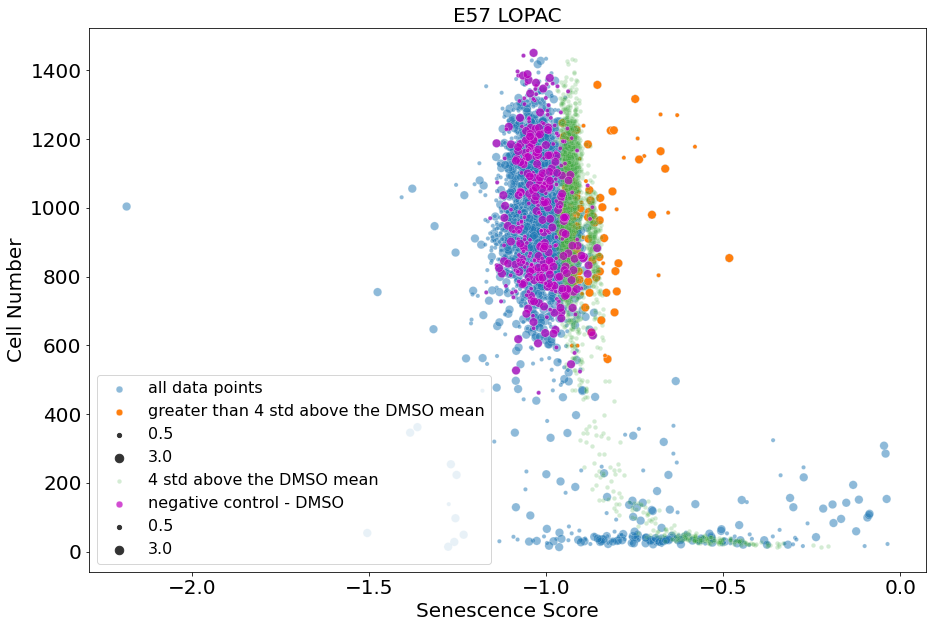

In [8]:
negative_control = (Data.set_index(['compound'])).loc[['DMSO']]

fig, axes = plt.subplots(1, figsize=(15,10))

sb.scatterplot(data=Data, y='cell_no', x='sen_score', alpha=0.5, s=20, label='all data points', legend=False, size='concentration')
sb.scatterplot(data=higher_500, y='cell_no', x='sen_score', label='greater than 4 std above the DMSO mean', s=20, size='concentration')
sb.scatterplot(data=Data, y='cell_no', x='DMSOsen_score+bootstrap_std4', s=20, alpha=0.2, label= '4 std above the DMSO mean')
sb.scatterplot(data=negative_control, y='cell_no', x='sen_score', label='negative control - DMSO', color='m', size='concentration', alpha=0.7)


plt.legend(fontsize=16)
plt.xlabel('Senescence Score', fontsize=20)
plt.ylabel('Cell Number', fontsize=20)
plt.title('E57 LOPAC', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

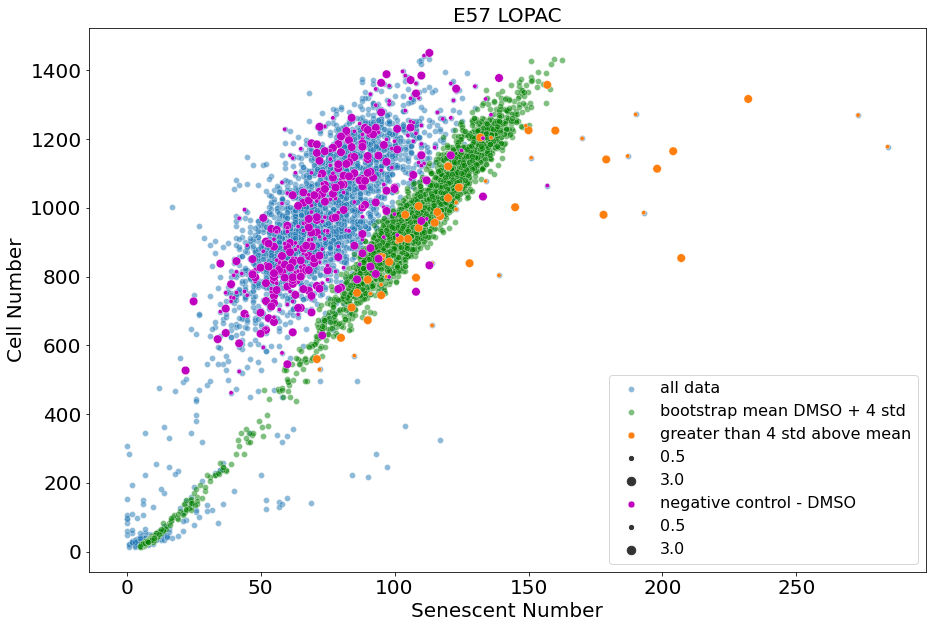

In [9]:
fig, axes = plt.subplots(1, figsize=(15,10))


sb.scatterplot(data=Data, y='cell_no', x='number_sen', alpha=0.5, label='all data', legend=False)
sb.scatterplot(data=Data, y='cell_no', x='DMSOnumber_sen+bootstrap_std4', alpha=0.5, color='g', label='bootstrap mean DMSO + 4 std')
sb.scatterplot(data=higher_500_number_sen, y='cell_no', x='number_sen', label='greater than 4 std above mean', size='concentration')
sb.scatterplot(data=negative_control, y='cell_no', x='number_sen', label='negative control - DMSO', color='m', size='concentration')

plt.legend(fontsize=16)
plt.xlabel('Senescent Number', fontsize=20)
plt.ylabel('Cell Number', fontsize=20)
plt.title('E57 LOPAC', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)